In [12]:
import torch 
import numpy as np
import pandas as pd

from utils import load_data_and_model, create_dataframe

### Load Model and Data
- freeze this and make copies for 
- need different things for non-accuracy
- have a script for saving and loading dataframes

- have LF sandbox with visualization/metric for LFs at the bottom after shifting things to utils.py
- percentage of data in each category

In [14]:
model_path = '/dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/RTE/RTE_16_35_57/best_model.pth'
csv_path = '/'.join(model_path.split('/')[0:-1])
split = 'dev' 

#Load model and data
model,dl = load_data_and_model(model_path,split)

#Create DataFrame of Raw Data, Predictions, and Labels
df_error = create_dataframe(model_path, model,dl)

Loading BERT model...



Loading RTE Dataset
Loading BERT model...



Loading BERT model...


100%|██████████| 9/9 [00:01<00:00,  4.92it/s]


### Saving and Loading Error DataFrame
**TODO: make this a python function**

In [5]:
def save_dataframe(df,filepath):
    df.to_csv(filepath, sep='\t')
    print('Saved dataframe to: ', filepath)
    
def load_dataframe(filepath):
    df = pd.read_csv(filepath, sep='\t')
    return df

filepath = f'{csv_path}/{split}_error_analysis.tsv'
save_dataframe(df_error,filepath)
df_error = load_dataframe(filepath)
df_error.head()

Saved dataframe to:  /dfs/scratch0/jdunnmon/mmtl/sota_quest/debugging/RTE/dev_error_analysis.tsv


,Unnamed: 0,sentence1,sentence2,score,label,is_wrong
0,0,"dana reeve , the widow of the actor christoph...",christopher reeve had an accident .,0.191707,0,False
1,1,"yet , we now are discovering that antibiotics...",bacteria is winning the war against antibioti...,0.473345,1,True
2,2,cairo is now home to some 15 million people -...,15 million tonnes of rubbish are produced dai...,0.738145,0,True
3,3,"the ami ##sh community in pennsylvania , whic...",pennsylvania has the biggest ami ##sh communi...,0.303975,0,False
4,4,security forces were on high alert after an e...,security forces were on high alert after a ca...,0.859430,1,False


### Looking at Random Examples

In [6]:
def print_row(row):
    print(f'sentence1: \t{row.sentence1}')
    print(f'sentence2: \t{row.sentence2}')
    print('score: \t{:.4f}'.format(row.score))    
    print(f'label: \t{row.label}')   
    print()

In [17]:
def print_random_pred(df):
    row = df.iloc[np.random.randint(df.shape[0])]
    print_row(row)

In [18]:
print("\033[1mINCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==True])
    
print("\033[1mCORRECT PREDICTIONS\033[0;0m")
for i in range(3):
    print_random_pred(df_error[df_error.is_wrong==False])

INCORRECT PREDICTIONS
sentence1: 	 as regards the headquarters building , the swiss are st ##ip ##ulating that they would transfer it to the w ##to for a value of about 51 million swiss franks . 
sentence2: 	 the w ##to headquarters are in switzerland . 
score: 	0.8847
label: 	0

sentence1: 	 " bea arthur and i first met when we did ' ma ##me ' together in 1965 . she became and has remained ' my bo ##som buddy ' ever since . i am deeply sad ##dened by her passing , but also relieved that she is released from the pain . i spoke to matt , her son , yesterday and i was aware that her time was imminent . she was a rare and unique performer and a dear , dear friend . " arthur passed away at her home on saturday at the age of 86 . angela lan ##sbury is appearing in the current revival of b ##lit ##he spirit which began preview performances on thursday , february 26 , 2009 and had an official opening on sunday , march 15 , 2009 at the shu ##bert theatre ( 225 west 44th street ) . 
sentence2: 

## Sandbox for Error Analysis

**1. We want to look at examples that are "barely" wrong and "barely" right since we have hope for boosts here.**

In [19]:
def print_barely_wrong_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==True]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    print_row(row)  
    
def print_barely_right_pred(df,thresh=0.05):
    df_temp = df[df.is_wrong==False]
    idx = np.where(np.abs(df_temp.score - 0.5) <= thresh)[0]
    row = df_temp.iloc[np.random.choice(list(idx))]
    print_row(row)

In [20]:
print("\033[1mBARELY WRONG\033[0;0m")
for i in range(3):
    print_barely_wrong_pred(df_error)
    
print("\033[1mBARELY RIGHT\033[0;0m")
for i in range(3):
    print_barely_right_pred(df_error)

BARELY WRONG
sentence1: 	 ibm stole trade secrets to copy two of its programs - - file - aid , a file manager , and abe ##nd - aid , a program that helps users locate the source of g ##lit ##ches . 
sentence2: 	 trade secrets were stolen . 
score: 	0.4644
label: 	1

sentence1: 	 nearly five months later on january 24 , 1935 , the passenger vessel mohawk sank after col ##lid ##ing with the norwegian motors ##hip tal ##isman , and 45 people lost their lives . 
sentence2: 	 100 or more people lost their lives in a ferry sinking . 
score: 	0.5415
label: 	0

sentence1: 	 although he has enough of a support base to be able to create a mass civil di ##so ##bed ##ience movement , some analysts think that his campaign will be , at best , a thorn in mr calderon ' s side . 
sentence2: 	 mr calderon is able to create a mass civil di ##so ##bed ##ience movement . 
score: 	0.5481
label: 	0

BARELY RIGHT
sentence1: 	 about 33 . 5 million people live in this massive con ##ur ##bation . i would guess t

**2. We also want to look at examples we got completely wrong since that could point to a systematic bias in the data/model. It could also help us find examples in the dataset that are mislabeled by human annotators**

In [21]:
def print_very_wrong_pred(df,thresh=0.95):
    df_temp = df[df.is_wrong==True]
    try:
        idx = np.where(np.abs(df_temp.score - df_temp.label) >= thresh)[0]
        row = df_temp.iloc[np.random.choice(list(idx))]
    except:
        print("Threshold too high, reducing by 0.05")
        idx = np.where(np.abs(df_temp.score - df_temp.label) >= thresh-0.05)[0]
        row = df_temp.iloc[np.random.choice(list(idx))]
    
    print_row(row) 

In [22]:
print("\033[1mVERY WRONG\033[0;0m")
for i in range(3):
    print_very_wrong_pred(df_error)

VERY WRONG
Threshold too high, reducing by 0.05
sentence1: 	 ah ##ern , who was travelling to tokyo for an eu - japan summit yesterday , will consult with other eu leaders by telephone later this week in an effort to find an agreed candidate . 
sentence2: 	 a summit between europe and japan is taking place in the japan ##ise capital . 
score: 	0.0712
label: 	1

Threshold too high, reducing by 0.05
sentence1: 	 today ' s best estimate of giant panda numbers in the wild is about 1 , 100 individuals living in up to 32 separate populations mostly in china ' s sichuan province , but also in sha ##an ##xi and gan ##su provinces . 
sentence2: 	 there are 32 panda ##s in the wild in china . 
score: 	0.9159
label: 	0

Threshold too high, reducing by 0.05
sentence1: 	 today ' s best estimate of giant panda numbers in the wild is about 1 , 100 individuals living in up to 32 separate populations mostly in china ' s sichuan province , but also in sha ##an ##xi and gan ##su provinces . 
sentence2: 	

**3. To find systematic errors, we can also look for correlations between certain features and the incorrectness a la Socratic**


We can make this way more sophisticated by perhaps using embeddings instead of this simple [BoW featurization](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer).

In [13]:
#Create a vector of correct/incorrect predictions
y = 2*(np.array(df_error.is_wrong.astype(float))-0.5) #TODO: use metal function

#Create corpus by combining sentences
combined = []
for a,b in zip(np.array(df_error.sentence1),np.array(df_error.sentence2)):
    combined.append(str(a)+str(b))

In [14]:
#Create BoW featurization
from sklearn.feature_extraction.text import CountVectorizer
corpus = np.array(list(df_error.sentence1))
vectorizer = CountVectorizer(ngram_range=(2,5), stop_words='english')
X = vectorizer.fit_transform(corpus)

#Run LR to find correlations
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(penalty="l1")
lr_model.fit(X, y)

/dfs/scratch0/vschen/venv-mmtl/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

10 000
harry potter
holy field
new government
award winning


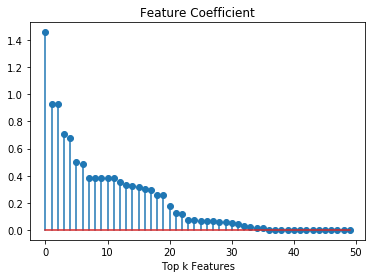

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.stem(np.sort(np.abs(lr_model.coef_)[0])[::-1][0:50])
plt.title('Feature Coefficient')
plt.xlabel('Top k Features')

top_idx = np.argsort(np.abs(lr_model.coef_)[0])[::-1][0:50]
names = vectorizer.get_feature_names()
for i in range(5):
    print (names[top_idx[i]])

In [23]:
print("\033[1mSYSTEMATIC EXAMPLES\033[0;0m")
for i in range(5):
    idx = list(np.where(X.todense()[:,top_idx[i]] == 1)[0])
    for ii in range(len(idx)):
        df_temp = df_error
        row = df_temp.iloc[idx[ii]]
        print_row(row)

SYSTEMATIC EXAMPLES
sentence1: 	 cairo is now home to some 15 million people - a bu ##rgeon ##ing population that produces approximately 10 , 000 tonnes of rubbish per day , putting an enormous strain on public services . in the past 10 years , the government has tried hard to encourage private investment in the refuse sector , but some estimate 4 , 000 tonnes of waste is left behind every day , fest ##ering in the heat as it waits for someone to clear it up . it is often the people in the poor ##est neighbourhoods that are worst affected . but in some areas they are fighting back . in shu ##bra , one of the northern districts of the city , the residents have taken to the streets armed with dust ##pan ##s and brushes to clean up public areas which have been used as public dump ##s . 
sentence2: 	 15 million tonnes of rubbish are produced daily in cairo . 
score: 	0.7381
label: 	0

sentence1: 	 the town is also home to the dalai lama and to more than 10 , 000 tibetan ##s living in exile